In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

PATH_FLOD = os.path.join(os.getcwd(), '..')

sys.path.append(os.path.abspath(PATH_FLOD))

In [2]:
VERBOSE = 0
N_JOBS = 2
MAX_ROUNDS = 4

In [3]:
from flod.classifiers.federatedbsvclassifier import FederatedBSVClassifier

In [4]:
from experiments.baseline import get_datasets, get_dataset_from_path

In [5]:
X, y = get_dataset_from_path(get_datasets()['pen-global'])

In [6]:
from sklearn.model_selection import train_test_split

X, _, y, _ = train_test_split(X, y, test_size=0.99)
len(X)

8

# IID

In [7]:
client_assigment = np.random.choice([0,1], size=len(X))

In [8]:
clf = FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, max_rounds=MAX_ROUNDS)

In [9]:
clf._compute_gamma(X, client_assigment)

(0.04420740357253006,
 [0.33053488966402117, 0.6694651103369923],
 [0.2027384665801732, 0.32467874521816303])

Round 0 of 3. Ws: [0. 0.]
Round 1 of 3. Ws: [ 0.01197914 -0.04834096]
Round 2 of 3. Ws: [-0.04829305  0.01284473]
Round 3 of 3. Ws: [-0.04791682  0.01213078]


/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


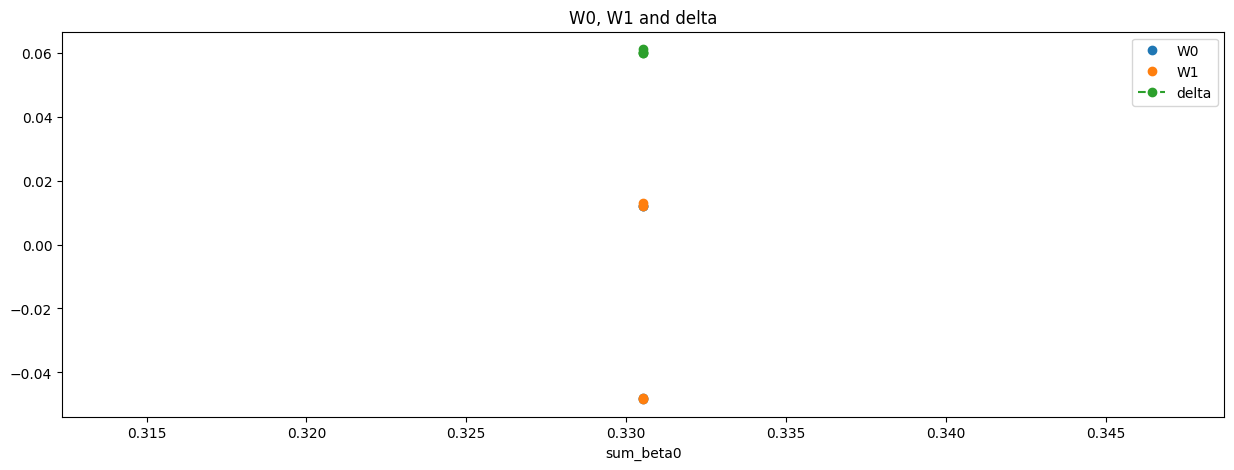


Fit over

{'sum_betas': array([0.33053489, 0.66946511]), 'f_norms': array([0.01698242, 0.00399657]), 'Ws': array([ 0.01213078, -0.04791682])}


FederatedBSVClassifier(max_rounds=4, normal_class_label=1,
                       outlier_class_label=-1)

In [10]:
def callback(debug):
    if len(debug) < MAX_ROUNDS:
        return
    debug = pd.DataFrame(debug)
    debug['delta'] = abs(debug['W0'] - debug['W1'])
    debug.plot(x='sum_beta0', y=['W0', 'W1', 'delta'], figsize=(15, 5), title='W0, W1 and delta', marker='o', style=['.','.','--'])
    plt.show()

clf.fit(X, y, client_assignment=client_assigment, round_callback=callback)

In [11]:
debug = pd.DataFrame(clf.debug)

In [12]:
debug['delta_W'] = abs(debug['W0'] - debug['W1'])
debug['delta_norm'] = abs(debug['f_norm0'] - debug['f_norm1'])
display(debug)

,round,W0,W1,f_norm0,f_norm1,sum_beta0,sum_beta1,delta_W,delta_norm
0,1,0.011979,-0.048341,0.016982,0.003997,0.330535,0.669465,0.060320,0.012986
1,2,-0.048293,0.012845,0.003997,0.016982,0.330535,0.669465,0.061138,0.012986
2,3,-0.047917,0.012131,0.003997,0.016982,0.330535,0.669465,0.060048,0.012986
3,4,0.012131,-0.047917,0.016982,0.003997,0.330535,0.669465,0.060048,0.012986


# Biased

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
client_assignment_biased = list(kmeans.fit_predict(X))

In [14]:
clf = FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, max_rounds=MAX_ROUNDS)
clf._compute_gamma(X, client_assignment_biased)

(0.0840035730572017,
 [0.5521829816577924, 0.4478170183432211],
 [0.31562051500367133, 0.2825109540484714])

Round 0 of 3. Ws: [0. 0.]
Round 1 of 3. Ws: [-0.04834096  0.01197914]
Round 2 of 3. Ws: [ 0.01213078 -0.04791682]
Round 3 of 3. Ws: [-0.04829305  0.01284473]


/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


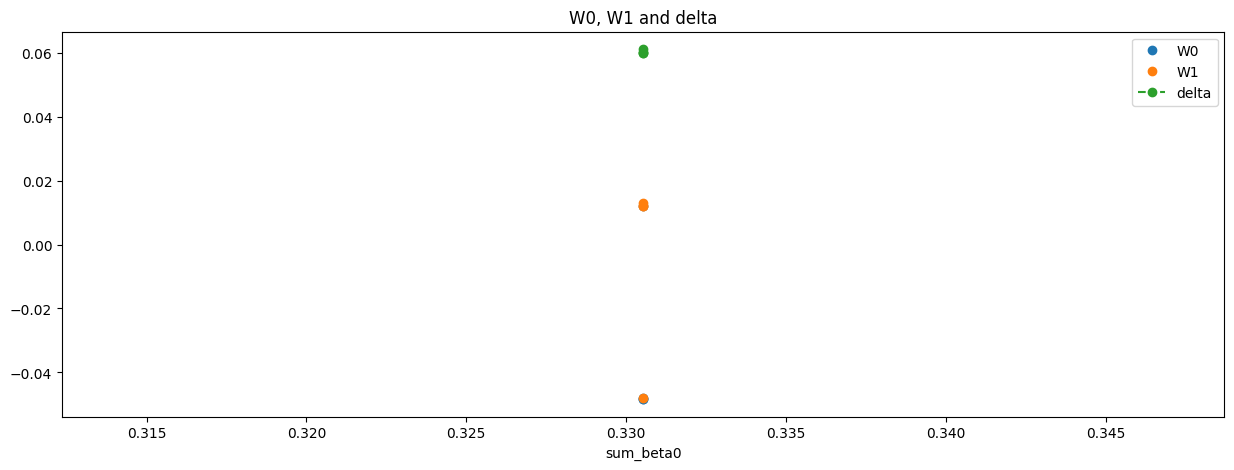


Fit over

{'sum_betas': array([0.33053489, 0.66946511]), 'f_norms': array([0.00399657, 0.01698242]), 'Ws': array([-0.04791682,  0.01213078])}


FederatedBSVClassifier(max_rounds=4, normal_class_label=1,
                       outlier_class_label=-1)

In [15]:
clf.fit(X, y, client_assignment=client_assigment, round_callback=callback)

In [16]:
debug = pd.DataFrame(clf.debug)

debug['delta_W'] = abs(debug['W0'] - debug['W1'])
debug['delta_norm'] = abs(debug['f_norm0'] - debug['f_norm1'])
display(debug)

,round,W0,W1,f_norm0,f_norm1,sum_beta0,sum_beta1,delta_W,delta_norm
0,1,-0.048341,0.011979,0.003997,0.016982,0.330535,0.669465,0.060320,0.012986
1,2,0.012131,-0.047917,0.016982,0.003997,0.330535,0.669465,0.060048,0.012986
2,3,-0.048293,0.012845,0.003997,0.016982,0.330535,0.669465,0.061138,0.012986
3,4,-0.047917,0.012131,0.003997,0.016982,0.330535,0.669465,0.060048,0.012986


# Toy Example

In [17]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, client_assigment = make_blobs(n_samples=6, centers=2, n_features=2, random_state=42)
y = [1 for _ in range(len(X))]

X = MinMaxScaler().fit_transform(X)

In [18]:
C = 1
q = 1

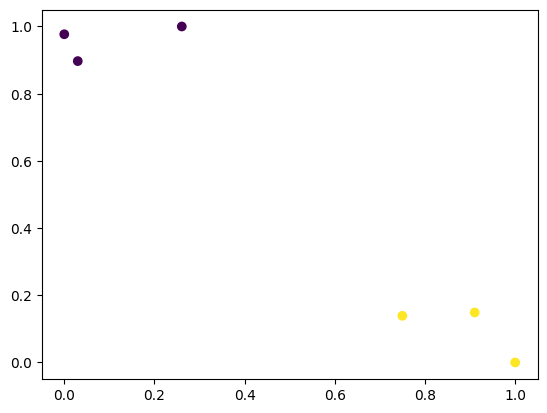

In [19]:
plt.scatter(X[:,0], X[:,1], c=client_assigment)
plt.show()

In [20]:
clf = FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, max_rounds=MAX_ROUNDS, C = C, q = q)
clf._compute_gamma(X, client_assigment)

(0.21458312506269706,
 [0.500000027693894, 0.4999999723066758],
 [0.5000000040573351, 0.49999997168128907])

Round 0 of 3. Ws: [0. 0.]
Round 1 of 3. Ws: [-0.1889995  -0.18748091]
Round 2 of 3. Ws: [-0.17700467 -0.17534128]
Round 3 of 3. Ws: [-0.17700466 -0.17534128]


/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


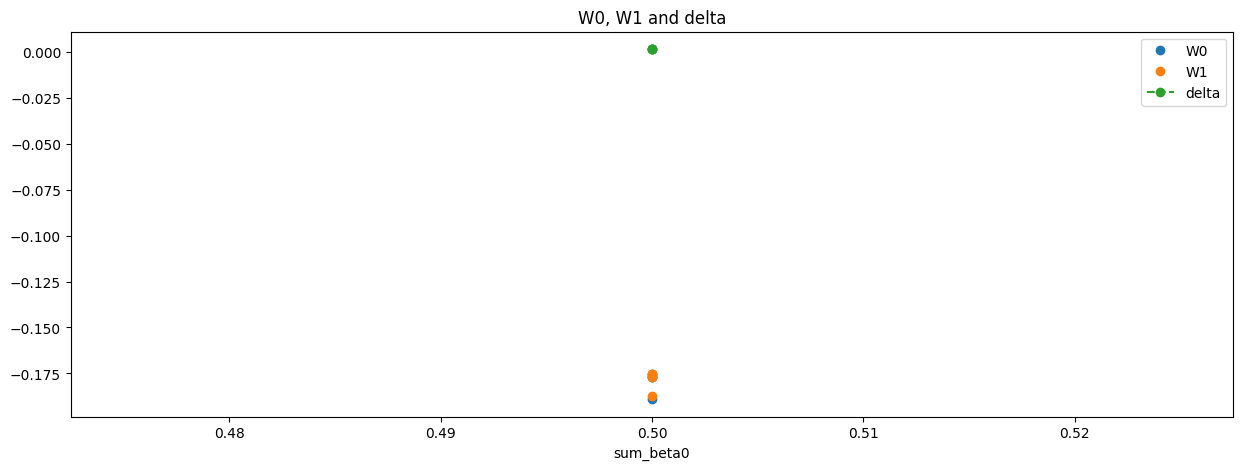


Fit over

{'sum_betas': array([0.50000003, 0.49999997]), 'f_norms': array([0.06361244, 0.06323176]), 'Ws': array([-0.17534128, -0.17700466])}


FederatedBSVClassifier(max_rounds=4, normal_class_label=1,
                       outlier_class_label=-1)

In [21]:
clf.fit(X, y, client_assignment=client_assigment, round_callback=callback)

In [22]:
debug = pd.DataFrame(clf.debug)

debug['delta_W'] = abs(debug['W0'] - debug['W1'])
debug['delta_norm'] = abs(debug['f_norm0'] - debug['f_norm1'])
display(debug)

,round,W0,W1,f_norm0,f_norm1,sum_beta0,sum_beta1,delta_W,delta_norm
0,1,-0.188999,-0.187481,0.063232,0.063612,0.5,0.5,0.001519,0.000381
1,2,-0.177005,-0.175341,0.063232,0.063612,0.5,0.5,0.001663,0.000381
2,3,-0.177005,-0.175341,0.063232,0.063612,0.5,0.5,0.001663,0.000381
3,4,-0.175341,-0.177005,0.063612,0.063232,0.5,0.5,0.001663,0.000381


In [23]:
np.average(clf.radiuses0), np.std(clf.radiuses0)

(0.4833713125401851, 1.956665470813507e-05)

In [24]:
np.average(clf.radiuses1), np.std(clf.radiuses1)

(0.48033576561703245, 4.202358108201798e-05)

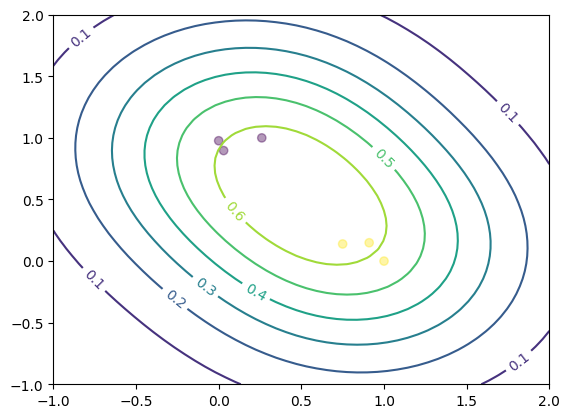

In [25]:
gx = np.linspace(min(X[:,0])-1, max(X[:,0])+1)
gy = np.linspace(min(X[:,1])-1, max(X[:,1])+1)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf.fc0(np.array([x, y])) + clf.fc1(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
#membership_contour = plt.contour(gX, gY, gZ, levels=((np.average(clf.radiuses0) + np.average(clf.radiuses1), )))
membership_contour = plt.contour(gX, gY, gZ)
plt.clabel(membership_contour, inline=1)

plt.scatter(X[:, 0], X[:, 1], c=client_assigment, alpha=.4)

plt.show()